## Warmup Project Model Iteration 2 Debrief

Here, I will summarize the common questions and areas of improvement that I saw in the warmup project model iteration 2 notebooks.

Topics include:
* Limitations of sklearn.feature_selection.SelectKBest
* Monotonic transformations to features
* Best practices for writing about and documenting your models
* Interpreting your Kaggle score

### Limitations of SelectKBest

Many of you utilized the suggestions in the dataquest.io tutorial for improving your model.  One of the suggestions that was given in that writeup was to do feature selection in order to remove irrelevant features.  This in itself is not a bad idea, however, the particular method that was used in the tutorial had a number of problems that we need to discuss.

For starters, let's revisit what was one in the dataquest.io tutorial to downselect to several informative features.  The next few cells perform the following high-level steps:
1.  Load the titanic training data
2.  Fill NaN's in the Embarked column with the column mode
3.  Fill NaN's in the Age column with the column mean
4.  Drop the Cabin column (there are too many missing values)
5.  Add dummy variables for both Sex and Embarked
6.  Add a column that indicates the title of the passenger
7.  Add a column for the family size of the passenger

In [1]:
import pandas as pd

data = pd.read_csv('../../datasets/titanic_train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


In [2]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
data.Embarked = data.Embarked.fillna(data.Embarked.mode()[0])
data.Age = data.Age.fillna(data.Age.mean())
if 'Cabin' in data.columns:
    data = data.drop(['Cabin'],axis=1)

print data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [4]:
data = pd.concat((data, pd.get_dummies(data.Sex)), axis=1)
data = pd.concat((data, pd.get_dummies(data.Embarked)), axis=1)
data.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Embarked', u'female', u'male',
       u'C', u'Q', u'S'],
      dtype='object')

In [5]:
import re

# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles and print how often each one occurs.
titles = data["Name"].apply(get_title)

# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Add in the title column.
data["Title"] = titles
data["FamilySize"] = data["SibSp"] + data["Parch"]

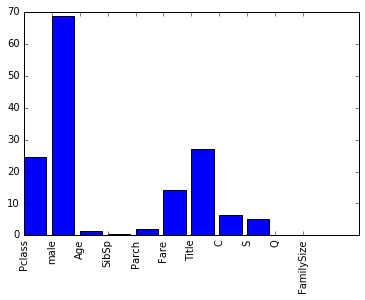

In [10]:
%matplotlib inline 
from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np

predictors = ["Pclass", "male", "Age", "SibSp", "Parch", "Fare", "Title", 'C', 'S', 'Q', 'FamilySize']

selector = SelectKBest(k=5)
selector.fit(data[predictors], data.Survived)
scores = -np.log10(selector.pvalues_)
plt.bar(range(len(scores)), scores)
plt.xticks(range(len(scores)), predictors, rotation="vertical")
plt.show()

In some ways this plot makes complete sense.  We know that being male meant you were likely to perish, and male has the highest feature importance.  Further, Pclass which we also know to be important is also selected.  What's puzzling is what doesn't get a high feature importance.  I would expect Age to have a much higher importance given the crucial role that it has in boosting your score on Kaggle (remember, women and children first).

To understand why this is happening we have to learn more about how `SelectKBest` works.  `SelectKBest` requires that you specify an argument called score_func  That has the following definision:

score_func : callable

    Function taking two arrays X and y, and returning a pair of arrays (scores, pvalues).

In this case we are using the score function `f_classif`.  If we read the documentation for `f_classif` we will learn that it uses an ANOVA (ANalysis Of VAriance) to determine how related each input feature in X is to the outputs, y, that we are trying to predict.  Unfortunately, the way that ANOVAs work in this case is to ask the question: "Is the mean value for a particular feature different for survivors versus non-survivors?".  If there is significant evidence that the mean values are different (i.e. not due to chance), then we say the feature is important or good.  Unfortunately, this is not always appropriate.  Next, we'll look at a minimalistic example of why this is problematic.

 #### Minimalistic Example
 
 We'll create two arrays, x and y, such that y can be perfectly predicted from x.

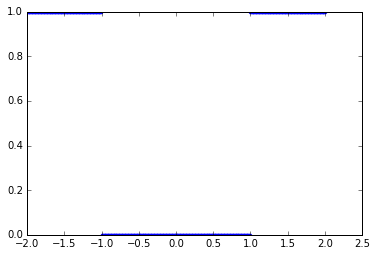

In [11]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-2, 2.01, .01)
y = abs(x) > 1
x = x[:,np.newaxis]
plt.plot(x,y,'b.')
plt.show()

In [12]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y)

classif = RandomForestClassifier()
classif.fit(x_train, y_train)
print "Accuracy of classifier", classif.score(x_test, y_test)

Accuracy of classifier 1.0


In [13]:
selector = SelectKBest(k=1)
selector.fit(x, y)
print "Feature importance", -np.log(selector.pvalues_)

Feature importance [ 0.07100401]


What has gone wrong here is that the ANOVA has declared x to be unimportant since the mean value for x when y = 1 is the basically the same as the mean value for x when y = 0.

#### Taking into Account Nonlinearities

Next, we'll discuss a method by which we can move beyond using ANOVA to compute feature importance.  I used [this](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) tutorial to generate this example for the titanic dataset.

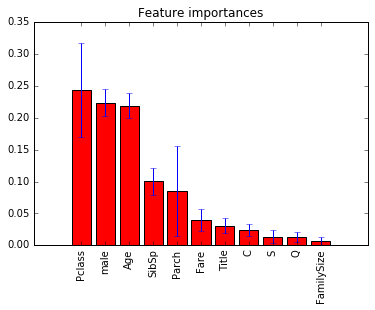

In [26]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250)
forest.fit(data[predictors], data.Survived)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)),
        importances[indices],
        color="r", yerr=std[indices],
        align="center")
plt.xticks(range(len(predictors)), predictors, rotation="vertical")
plt.show()

#### Overestimating Performance

There is a second problem with the DataQuest code.  The issue is with the following piece of code.

```python
selector = SelectKBest(k=5)
selector.fit(data[predictors], data.Survived)
scores = -np.log10(selector.pvalues_)```

The problem is that the best features are being estimated using *all* of the training data.  Therefore, if we then use cross validation to estimate performance we will be implicitly using some knowledge from the test set in our cross validation loop since we used the features that were best over all the data.

First, let's run an experiment to see the effect that the DataQuest tutorial's method has.

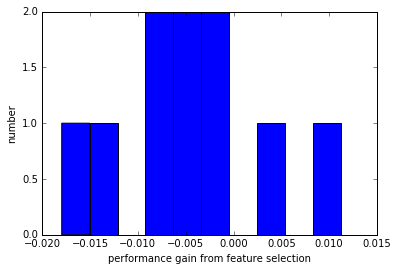

In [27]:
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression

def do_trial(alg, X1, X2, y):
    # change Shuffle to False to see how this affects the conclusions
    cv = cross_validation.StratifiedKFold(y, 3, shuffle=True)
    score1 = cross_validation.cross_val_score(alg, X1, y, cv=cv)
    score2 = cross_validation.cross_val_score(alg, X2, y, cv=cv)
    return score1.mean(), score2.mean()

predictors = ['Pclass',
              'male',
              'Age',
              'SibSp',
              'Parch',
              'Fare',
              'Title',
              'C',
              'S',
              'Q',
              'FamilySize']

X = np.asarray(data[predictors])
y = np.asarray(data.Survived)

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)
best_feature_indices = sorted(range(len(scores)), reverse=True, key=lambda i: scores[i])

alg = RandomForestClassifier(n_estimators=150, min_samples_split=8, min_samples_leaf=4)
#alg = LogisticRegression()

n_trials = 10
all_features_performances = np.zeros(n_trials,)
best_features_performances = np.zeros(n_trials,)

for i in range(n_trials):
    (all_features_performances[i], best_features_performances[i]) = \
            do_trial(alg, X, X[:, best_feature_indices[0:5]], y)

plt.hist(best_features_performances - all_features_performances)
plt.ylabel('number')
plt.xlabel('performance gain from feature selection')
plt.show()

Next, we'll add a bunch of random features to X.  These features will be determined completely at random and should have no real linkage to the variable we are trying to predict.

Feature selection performance 0.840404, original features performance 0.801908


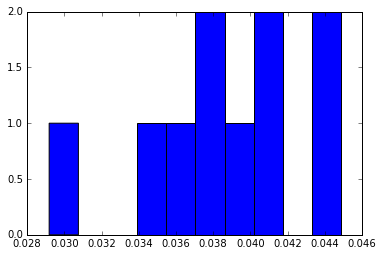

In [28]:
X = np.asarray(data[predictors])
X = np.hstack((X, np.random.randn(X.shape[0], 10000)))

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(X, y)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)
best_feature_indices = sorted(range(len(scores)), reverse=True, key=lambda i: scores[i])

#alg = RandomForestClassifier(n_estimators=150, min_samples_split=8, min_samples_leaf=4)
alg = LogisticRegression()

n_trials = 10
all_features_performances = np.zeros(n_trials,)
best_features_performances = np.zeros(n_trials,)

for i in range(n_trials):
    (all_features_performances[i], best_features_performances[i]) = \
            do_trial(alg, X[:,0:len(predictors)], X[:, best_feature_indices[0:60]], y)

print "Feature selection performance %f, original features performance %f" \
            % (best_features_performances.mean(), all_features_performances.mean())
plt.hist(best_features_performances - all_features_performances)
plt.show()

#### Fairly evaluating performance

In order to do a fair evaluation, you would have to do your feature selection within your cross validation loop.  Specifically, for each cross validation fold you would have to do select the best features on only the training data for that fold.  The performance would then be evaluated on the testing data for that fold.  In this way, the selected features could vary across folds.

### Monotonic Transformations

Several people tried transforming their data using various monotonic functions (e.g. the log or the square of a number, provided it's positive).  While these transformations can make a difference for a model like logistic regression, they will not make a difference for something like a decision tree.

This is a specific example of a broader need to consider feature engineering within the context of a particular model that you are investigating.

### Best Practices for Documenting Your Models

Based on what I saw in the model iteration 2 notebook's, here are a few things that I really liked.

#### List Your References up Front

When folks put a list of all the references they used up front, it really helped frame my engagement with the notebook.  I recommend doing this in a front matter section after your notebook abstract, but before you dive into your paticular models.

#### Cite your sources throughout

Whenever you try something out that was motivated by another source, put in a citation.  You could either do this by the name of the source, or you could do it using some sort of reference numbering system (similar to a bibliography).  Maybe there is even a way to automate this process in Jupyter (something similar to bibtex)?

#### Situate Your Current Investigations

Several people explicitly referenced results from their earlier notebooks as a way to motivate the models they were trying in iteration 2.  I found this to be very effective.  The exact format of these references varied significantly (e.g. reproducing a visualization, talking about a prior result).  I think any method is fine, but I would make sure that it is specific enough that you can unambiguously find the analysis that you are referencing.

### Interpreting Your Kaggle Score

I'll talk about several issues that arise when interpreting your Kaggle score.  I mean this both from a self-efficacy standpoint as well as a technical standpoint.